In [171]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from myDataSet import *
from tqdm import tqdm

In [172]:
def batch_data(data: torch.Tensor,
               labels: torch.Tensor,
               batch_size: int,
               randomize: bool = False) -> tuple[list[torch.Tensor],list[torch.Tensor]]:
    """
    Takes the input data, shuffles it randomly and repacks it in batches of
    'batch_size'. If len(labels) % batch_size != 0, the final number of
    batches is rounded down.

     Parameters:
    - data: A torch Tensor of shape (nr. data points, nr. channels, height, width).
    - labels: Either tuple, list or 1d numpy array containing the labels for the data.
    - batch_size: The number of data points contained within each batch.
    - randomize: A boolean determining whether the data is randomly shuffled.

     Returns:
    - batches: A tuple of (X_batches, Y_batches)
    """
    assert type(data) is torch.Tensor and len(data.shape) == 4
    assert type(labels) is torch.Tensor and len(labels.shape) == 2

    _indices = [i for i in range(len(labels))]
    if randomize:
        _indices = torch.randperm(len(_indices))
        _indices = _indices.tolist()

    _X_batches, _Y_batches = [], []
    for _batch in range(len(labels) // batch_size):
        _i= _indices[batch_size*_batch : batch_size*(_batch+1)]
        _X_batches.append(data[_i,::])
        _Y_batches.append(labels[_i,::])

    batches = _X_batches, _Y_batches
    return batches

def one_hot(labels: tuple | list) -> torch.Tensor:
    """
    Creates a one-hot encoding of given labels.

     Parameters:
    - labels: tuple or list containing labels.

     Returns:
    - one_hot_Y: 2D torch Tensor of shape (nr. data points, nr. classes).
    """
    assert type(labels) is tuple or type(labels) is list, f'Unrecognized labels type: should be tuple or list.'
    # Creating map from label to integer
    label_dict = {}
    for class_idx, label in enumerate(set(labels)):
        label_dict[label] = class_idx
    # Calculating Number of data points x Nr of classes one-hot encoding of Y
    nr_labels = len(list(labels))
    nr_unique_labels = len(list(label_dict.keys()))
    one_hot_Y = torch.zeros(size=(nr_labels, nr_unique_labels))
    for i, label in enumerate(labels):
        one_hot_Y[i][label_dict[label]] = 1
    return one_hot_Y

def normalize_pixels(data: torch.Tensor) -> None:
    """
    Void type function normalizing every value: (0,255) -> (0,1), in input tensor.

     Parameters:
    - data: 4D torch tensor of data of shape (nr. datapoints, nr. channels, height, width)

    """
    _PIXEL_MAX = 255
    for data_point in range(data.shape[0]):
        data[data_point] *= 1.0/_PIXEL_MAX

def accuracy(y_hat: torch.Tensor,
             y_actual: torch.Tensor) -> float:
    """
    Function for calculating the accuracy of 'y_hat' against 'y_actual'
    in terms of: nr. agreements / nr. comparisons.

     Parameters:
    - y_hat: 2D torch tensor of shape (nr. datapoints, nr. classes) only containing 1 and 0.
    - y_actual: 2D torch tensor of shape (nr. datapoints, nr. classes) only containing 1 and 0.

     Returns:
    - _accuracy: float in range (0,1).
    """
    assert y_hat.shape == y_actual.shape, f'Inputs are not of matching shapes.'
    _nr_equals = torch.sum(y_hat*y_actual)
    _accuracy = _nr_equals/y_hat.shape[0]
    return _accuracy

In [173]:
class NeuralNet(torch.nn.Module):

    def __init__(self, channels_in: int,
                        nr_classes: int,
                 input_dimensions: tuple[int,int]) -> None:
        super(NeuralNet, self).__init__()
        self.input_dim = input_dimensions
        self.nr_classes = nr_classes

        # layer 1: convolutional layer
        self.conv1 = torch.nn.Conv2d(in_channels=channels_in,
                                    out_channels=6,
                                     kernel_size=(5,5),
                                          stride=(1,1),
                                         padding=(0,0))
        # activation function
        self.activation1 = torch.nn.ReLU()
        object_dim1 = self.output_dim(self.input_dim,
                                      self.conv1.kernel_size,
                                      self.conv1.stride,
                                      self.conv1.padding)
        #--------------------------------------#

        # layer 2: pooling layer
        self.pool1 = torch.nn.AvgPool2d(kernel_size=(2,2),
                                             stride=(1,1),
                                             padding=(0,0))

        object_dim2 = self.output_dim(object_dim1,
                                      self.pool1.kernel_size,
                                      self.pool1.stride,
                                      self.pool1.padding)

        #--------------------------------------#

        # layer 3: convolutional layer
        self.conv2 = torch.nn.Conv2d(in_channels=6,
                                    out_channels=16,
                                     kernel_size=5,
                                          stride=(1,1),
                                         padding=(0,0))
        # activation function
        self.activation2 = torch.nn.ReLU()
        object_dim3 = self.output_dim(object_dim2,
                                      self.conv2.kernel_size,
                                      self.conv2.stride,
                                      self.conv2.padding)
        #--------------------------------------#

        # layer 4: pooling layer
        self.pool2 = torch.nn.AvgPool2d(kernel_size=(2,2),
                                             stride=(1,1),
                                             padding=(0,0))

        object_dim4 = self.output_dim(object_dim3,
                                      self.pool2.kernel_size,
                                      self.pool2.stride,
                                      self.pool2.padding)
        # flattening
        self.flatten = torch.nn.Flatten(start_dim=1,end_dim=-1)

        #--------------------------------------#

        # layer 5: fully connected layer (lazy means input dim is automatically inferred)
        in_vector_length = self.conv2.out_channels*object_dim4[0]*object_dim4[1]
        self.lin1 = torch.nn.Linear(in_features=in_vector_length,
                                    out_features=120)

        # activation function
        self.activation3 = torch.nn.ReLU()

        #--------------------------------------#

        # layer 6: fully connected layer (lazy means input dim is automatically inferred)
        self.lin2 = torch.nn.Linear(in_features=self.lin1.out_features,
                                    out_features=self.nr_classes)


    @staticmethod
    def output_dim(data_size: tuple[int, int],
                   kernel_size: tuple[int, int],
                   stride_size: tuple[int, int] = (1,1),
                   padding_size: tuple[int, int] = (0,0)) -> tuple[int, int]:
        """
        Calculates output shape of array after convolution w. specific
        kernel, padding and stride.

         Parameters:
        - data_size: tuple containing dimension of 2D input array.
        - kernel_size: tuple containing dimension of 2D kernel.
        - stride_size: tuple containing dimension of 2D stride.
        - padding_size: tuple containing dimension of 2D padding.

         Returns:
        - output_dimensions: tuple containing dimension of resulting 2D array.
        """

        out_height = ((data_size[0] - kernel_size[0] + 2 * padding_size[0]) // stride_size[0]) + 1
        out_width = ((data_size[1] - kernel_size[1] + 2 * padding_size[1]) // stride_size[1]) + 1

        output_dimensions = (out_height, out_width)
        return output_dimensions

    def predict(self, forwarded_data:torch.Tensor) -> torch.Tensor:
        """
        Takes the raw estimate from a forward pass (nr. data points, nr. classes)
        and sets the highest val in each row 1 and the rest zero.

         Parameters:
        - forwarded_data: torch.Tensor of shape (nr. data points, nr. classes)

         Returns:
        - _prediction: torc.Tensor of shape (nr. data points, nr. classes)

        """
        assert forwarded_data.shape[1] == self.nr_classes, f'Forwarded data should be of shape (nr. data points, nr. classes).'
        assert len(forwarded_data.shape) == 2, f' Forwarded data should be a 2D tensor.'
        _prediction = torch.zeros(size=forwarded_data.shape)
        _prediction[:,torch.argmax(forwarded_data,dim=1)] = 1
        return _prediction

    def forward(self, data):
        assert len(data.shape) == 4, f'Shape of X should be (nr. data points, nr. channels, height, width)'
        data = self.conv1(data)
        data = self.activation1(data)
        data = self.pool1(data)
        data = self.conv2(data)
        data = self.activation2(data)
        data = self.pool2(data)
        data = self.flatten(data)
        data = self.lin1(data)
        data = self.activation3(data)
        data = self.lin2(data)
        return data


def train(model: NeuralNet,
          data_batches: list[torch.Tensor],
          labels_batches: list[torch.Tensor],
          epochs: int = 10) -> tuple[list,list]:


    _optimizer = torch.optim.SGD(params=model.parameters(),
                                 lr=0.001,
                                 momentum=0.9)

    _loss_function = torch.nn.CrossEntropyLoss()

    _accuracies = []
    _losses = []
    for epoch in tqdm(range(epochs)):
        _counter = 0
        _batch_acc = 0
        _batch_loss = 0
        #print("Epoch: ", epoch)
        for x_batch, y_batch in zip(data_batches,labels_batches):
        #    print("--batch--")

            # Ensure that parameter gradients are 0.
            _optimizer.zero_grad()

            # Forward pass
            _y_hat = model.forward(x_batch)
            assert _y_hat.shape[0] == labels_batches[0].shape[0]
            assert _y_hat.shape[1] == model.nr_classes

            # Loss calculation + backprop + optimization
            _loss = _loss_function(_y_hat,y_batch)
            _loss.backward()
            _optimizer.step()

            _batch_acc += accuracy(model.predict(_y_hat),y_batch).item()
            _batch_loss += _loss.item()
            _counter += 1

        _accuracies.append(_batch_acc/_counter)
        _losses.append(_batch_loss/_counter)

    return _accuracies, _losses



In [174]:
# Set up the dataset.
image_directory = "Insects"
annotations_file_directory = "insects.csv"
dataset = MyCustomImageDataset(annotations_file_directory, image_directory)

# Loading entire dataset
X, Y = dataset.X, list(dataset.Y)
X = X.to(torch.float32) # Network is expecting input of floating type digits
print(X.shape,",",len(Y))

torch.Size([724, 3, 520, 520]) , 724


In [175]:
# One-hot encoding labels
Y = one_hot(Y)

In [176]:
# Normalizing X-data
normalize_pixels(X)

In [177]:
# Batching entire dataset into batches of 'my_batch_size'
my_batch_size = 2
my_X_batches, my_Y_batches = batch_data(data=X,
                                        labels=Y,
                                        batch_size=my_batch_size,
                                        randomize=True)
print("Initial nr. of batches: ", len(my_X_batches))

# Picking out 'my_fraction' part of total data
my_fraction = 0.008
my_X_batches = my_X_batches[:int(my_fraction*len(my_X_batches))]
my_Y_batches = my_Y_batches[:int(my_fraction*len(my_Y_batches))]
print("Final nr. of batches: ", len(my_X_batches))

Initial nr. of batches:  362
Final nr. of batches:  2


In [178]:
# Creating instance of neural network
my_nr_channels = my_X_batches[0].shape[1]
my_nr_classes = 3
my_input_dimensions = (my_X_batches[0].shape[2], my_X_batches[0].shape[3])

my_net = NeuralNet(channels_in=my_nr_channels,
                   nr_classes=my_nr_classes,
                   input_dimensions=my_input_dimensions)

In [179]:
accuracies, losses = train(model=my_net,
                    data_batches=my_X_batches,
                  labels_batches=my_Y_batches,
                          epochs=20)

100%|██████████| 20/20 [01:00<00:00,  3.02s/it]


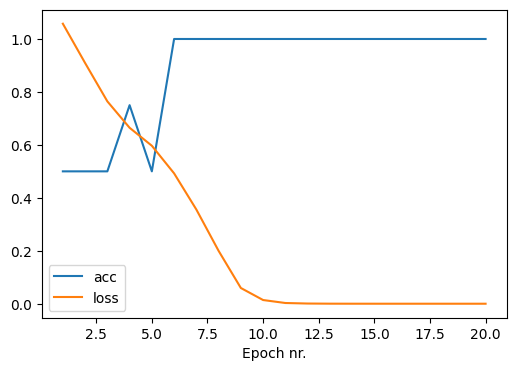

In [181]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
epochs = [i+1 for i in range(len(accuracies))]
ax.plot(epochs,accuracies,label="acc")
ax.plot(epochs,losses,label="loss")
ax.set_xlabel("Epoch nr.")
ax.legend()
plt.show()